In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Read Data

In [9]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
data_path_am = 'Data/Amazon/'
data_path_ml = 'Data/ML/'

# Full datasets

In [10]:
# Amazon
df_am = pd.read_pickle(path + data_path_am + 'Amazon_full')
df_am['item_id'] = df_am.item.astype('category').cat.codes
df_am['user_id'] = df_am.user.astype('category').cat.codes

# MovieLens
df_ml = pd.read_pickle(path + data_path_ml + 'ML_full')
df_ml['item_id'] = df_ml.item.astype('category').cat.codes
df_ml['user_id'] = df_ml.user.astype('category').cat.codes

# Subsets

In [11]:
# Amazon
am_like_ml = pd.read_pickle(path + data_path_am + 'am_like_ml')
am_20k_users = pd.read_pickle(path + data_path_am + 'am_20k_users')

# MovieLens
ml_1m = pd.read_pickle(path + data_path_ml + 'ml_1m')

## Amazon
- 20k users with > 5 items

In [53]:
df_am = df_am[df_am.groupby('user_id')['user_id'].transform('count').ge(5)]

In [61]:
from Data_prep import leave_users_out
_, am_20k_users = leave_users_out(df_am, 20000)

In [70]:
am_20k_users['item_id'] = am_20k_users.item.astype('category').cat.codes
am_20k_users['user_id'] = am_20k_users.user.astype('category').cat.codes

In [111]:
am_20k_users.drop(columns=['user', 'item']).to_pickle(path + data_path + 'Amazon/am_20k_users')

In [95]:
len(am_20k_users)

180809

In [66]:
am_20k_users.nunique()

user        20000
item        90395
datetime     3049
rating          5
item_id     90395
user_id     20000
dtype: int64

## AM like ML_1M
- 6040 users with >20 items rated per user, similar to ML_1M

In [5]:
am_like_ml_6k = am_like_ml

In [6]:
df_am_20 = df_am[df_am.groupby('user_id')['user_id'].transform('count').ge(20)]

In [7]:
df_am_20 = df_am_20.drop(am_like_ml_6k.index)

In [10]:
from Data_prep import leave_users_out
_, forty = leave_users_out(df_am_20, 40)

In [14]:
forty.user_id.nunique()
forty['item_id'] = forty.item.astype('category').cat.codes
forty['user_id'] = forty.user.astype('category').cat.codes
forty['user_id'] = forty.user_id + 6000

In [21]:
am_like_ml = pd.concat([am_like_ml_6k, forty]).drop(columns=['user', 'item'])

In [51]:
am_like_ml['item_id'] = am_like_ml.item.astype('category').cat.codes
am_like_ml['user_id'] = am_like_ml.user.astype('category').cat.codes

In [22]:
am_like_ml.nunique()

datetime     2949
rating          5
item_id     86843
user_id      6040
dtype: int64

In [23]:
am_like_ml.to_pickle(path + data_path_am + 'am_like_ml')

# Movielens

#### ML 1M

In [77]:
ml_1m = pd.read_pickle(path + data_path + '/ML/ml_1m')

#### ML 25M

In [85]:
df_ml = df_ml[df_ml.groupby('user_id')['user_id'].transform('count').ge(5)]

In [107]:
df_ml.nunique()

user          162541
item           59047
rating            10
datetime    20115267
item_id        59047
user_id       162541
dtype: int64

---
# Train Test Val Splits

In [24]:
from Data_prep import leave_last_out

In [25]:
def data_split(df, n):
    users_ids = np.random.choice(df['user_id'].unique(), n, replace=False)
    n_set = df[df['user_id'].isin(users_ids)]
    remaining_set = df.drop(n_set.index)
    return remaining_set, n_set

In [26]:
def create_cfrnn_mf_splits(df, n_test_users, n_val_users, store_path='', file_name=''):
    train_temp, test_set_cfrnn = data_split(df, test_users)
    train_set_cfrnn, val_set_cfrnn = data_split(train_temp, val_users)
    
    add_to_train, val_set_mf = leave_last_out(val_set_cfrnn)
    add_to_train_2, test_set_mf = leave_last_out(test_set_cfrnn)
    train_set_mf = pd.concat([train_set_cfrnn, add_to_train, add_to_train_2])
    
    if len(store_path) > 0:
        train_set_cfrnn.to_pickle(store_path + file_name + '_train_cfrnn')
        test_set_cfrnn.to_pickle(store_path + file_name + '_test_cfrnn')
        val_set_cfrnn.to_pickle(store_path + file_name + '_val_cfrnn')
        
        train_set_mf.to_pickle(store_path + file_name + '_train_mf')
        test_set_mf.to_pickle(store_path + file_name + '_test_mf')
        val_set_mf.to_pickle(store_path + file_name + '_val_mf')
    
    return [train_set_cfrnn, test_set_cfrnn, val_set_cfrnn, train_set_mf, test_set_mf, val_set_mf]

In [27]:
def split_stats(dfs):
    d = {}
    split_types = ['train_cfrnn', 'test_cfrnn', 'val_cfrnn', 'train', 'test', 'val']
    for df, split_type in zip(dfs, split_types):
        d[split_type + '_n_users'] = df.user_id.nunique()
    return pd.DataFrame.from_dict(d, orient='index')[0]

In [28]:
test_users = 1000
val_users = 500

In [124]:
splits = create_cfrnn_mf_splits(am_20k_users, test_users, val_users, store_path=path + data_path_am, file_name='am_20k_users')

In [29]:
splits_am_like_ml = create_cfrnn_mf_splits(am_like_ml, test_users, val_users, store_path=path + data_path_am, file_name='am_like_ml')

In [126]:
splits_ml_1m = create_cfrnn_mf_splits(ml_1m, test_users, val_users, store_path=path + data_path_ml, file_name='ml_1m')

In [130]:
import xlsxwriter
dfs = [splits, splits_am_like_ml, splits_ml_1m]
sheet_names = ['am_20k_users', 'ml_1m', 'am_like_ml']

writer = pd.ExcelWriter(path + 'Data/EDA/' + 'train_test_val_splits_stats.xlsx', engine='xlsxwriter')
for df, sheet_name in zip(dfs, sheet_names):
    res = split_stats(df)
    res.to_excel(writer, sheet_name=sheet_name)
writer.save()

## MF Sets

---
# EDA Comparison

In [118]:
def eda_comp(dfs=[], plot_title='', legend_names=[], colors=[], size=(20,8), store_path='', **kwargs):
    figure, axes = plt.subplots(nrows=1, ncols=3, figsize=size)
    if len(plot_title) > 0:
        figure.suptitle(plot_title)
    figure.subplots_adjust(wspace=0.6)
    
    for i, df in enumerate(dfs):
        axes[0].bar(i, df.user_id.nunique(), color=colors[i])
        axes[1].bar(i, df.item_id.nunique(), color=colors[i])
        axes[2].bar(i, len(df), color=colors[i])
        
        
    axes[0].set_title('Number of Users')
    axes[0].set_xticks([])
    axes[0].set_ylabel('User Count')
    
    axes[1].set_title('Number of Items')
    axes[1].set_xticks([])
    axes[1].set_ylabel('Item Count')
    
    axes[2].set_title('Number of Ratings')
    axes[2].set_xticks([])
    axes[2].set_ylabel('Rating Count')
    t = axes[2].yaxis.get_offset_text()
    t.set_x(-0.14)
    
    figure.legend(legend_names, loc='lower center', ncol=len(legend_names), fontsize='large')
    
    if len(store_path) > 0:
        figure.savefig(store_path + '.pdf')

In [80]:
plt.rcParams.update({'font.size': 30})

In [81]:
colors = {'ml_1m':(0.2, 0.2, 0.6), 'am_like_ml':(0.6, 0.2, 0.2), 'am_20k_users':(0.2, 0.6, 0.2)}
colors.values()

dict_values([(0.2, 0.2, 0.6), (0.6, 0.2, 0.2), (0.2, 0.6, 0.2)])

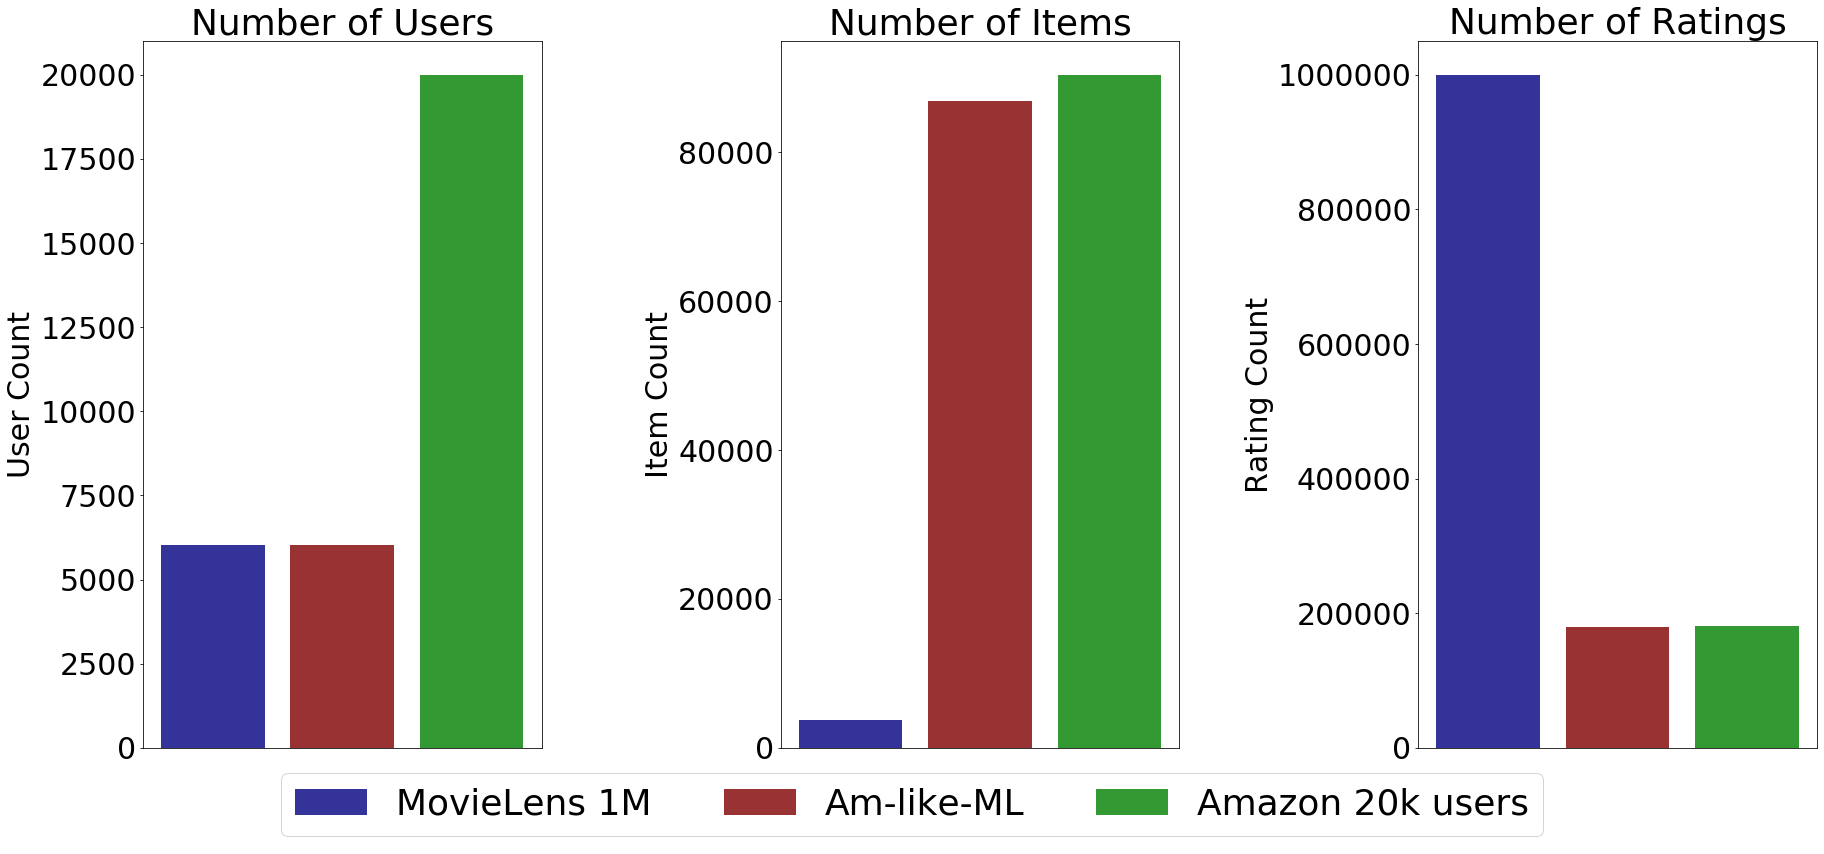

In [108]:
eda_comp(dfs=[ml_1m, am_like_ml, am_20k_users], 
         size=(30,13), 
         legend_names=['MovieLens 1M', 'Am-like-ML','Amazon 20k users'], 
         colors=list(colors.values()),
         store_path=path + 'Plots/EDA/subsets_comp')

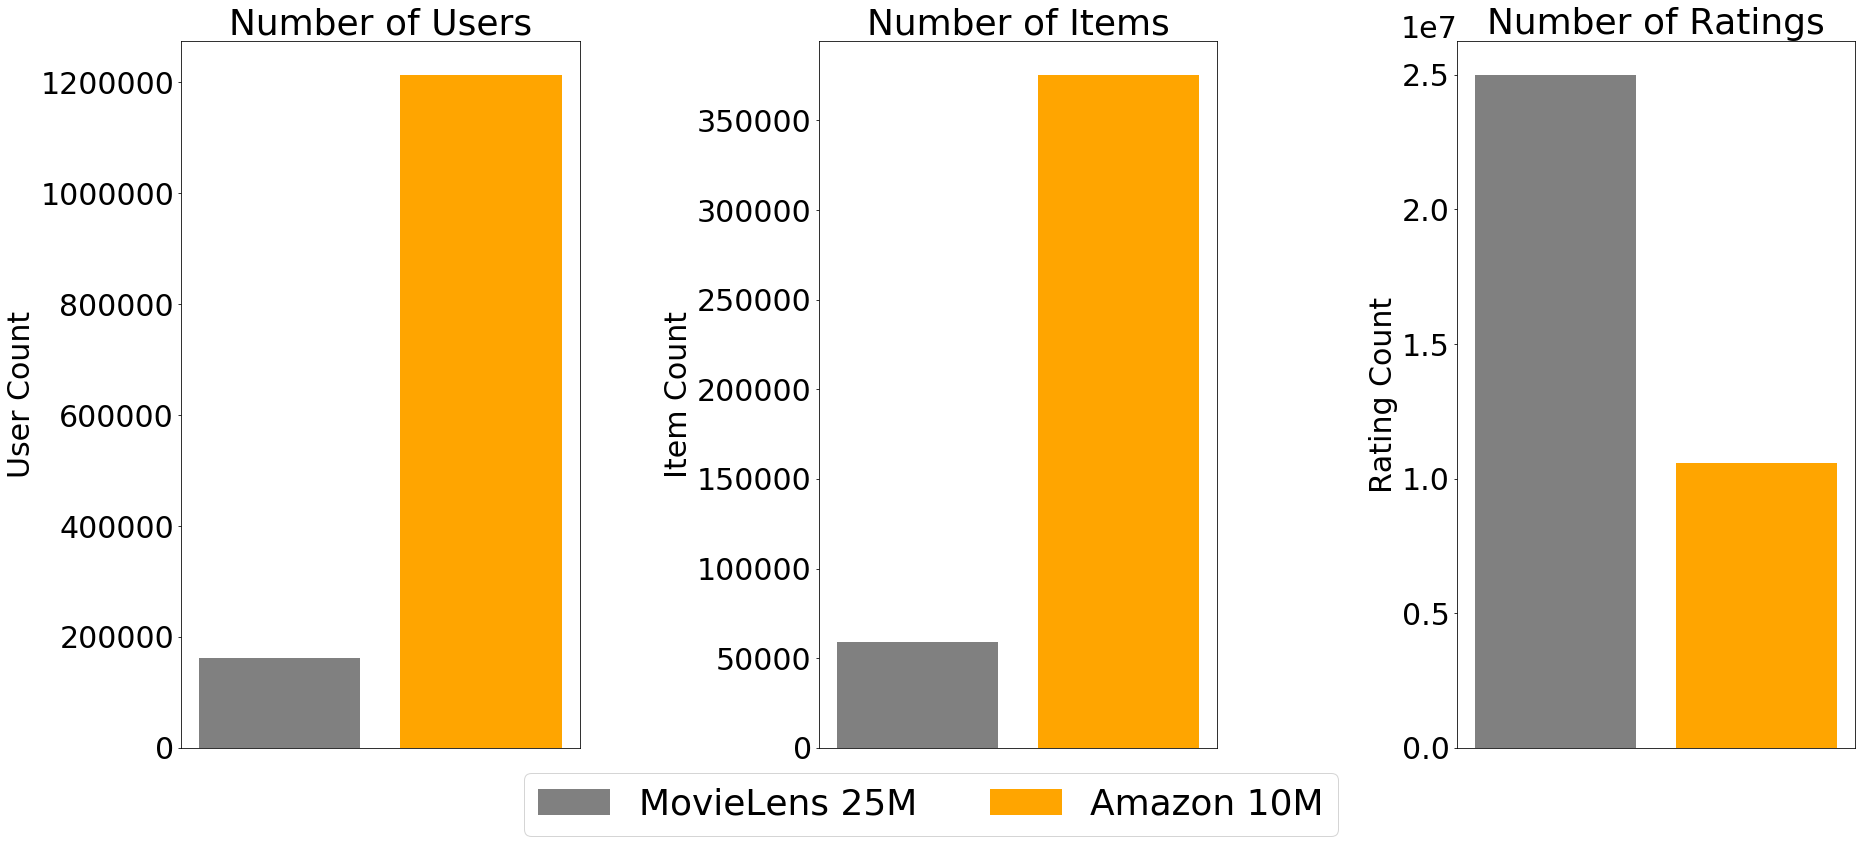

In [127]:
eda_comp([df_ml, df_am], size=(30,13), store_path=path + 'Plots/EDA/full_data_comp', legend_names=['MovieLens 25M', 'Amazon 10M'], colors=['grey', 'orange'])

---
# EDA plots per dataset

### Visualisation

In [120]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator

def eda_plots(df, title, size=(20,16), store_path='', color=(), **kwargs):
    
    user_counts = df.groupby('user_id')['item_id'].count()
    item_counts = df.groupby('item_id')['user_id'].count().sort_values(ascending=True)
    norpu = user_counts.mean()
    norpi = item_counts.mean()
    
    fig = plt.figure(figsize=size)
    if len(title) > 0:
        fig.suptitle(title, x=0.5, y=0.95, fontsize=22)
    gs = fig.add_gridspec(2,2, wspace=0.4, hspace=0.4)
    
    f_ax1 = fig.add_subplot(gs[0,0:])
    plt.hist(user_counts, bins = kwargs['user_bins'], color=color)
    plt.xticks(np.arange(0, kwargs['user_bins'], kwargs['user_steps']), np.arange(0, kwargs['user_bins'], kwargs['user_steps']))
    plt.xlim(kwargs['user_xlim'])
    plt.title('Number of Ratings per User')
    plt.xlabel('Ratings per User')
    plt.ylabel('Count')
    plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
    plt.gca().xaxis.get_majorticklabels()[0].set_x(-0.05)
    
    f_ax3 = fig.add_subplot(gs[1,0])
    plt.hist(item_counts, bins = kwargs['item_bins'], color=color)
    plt.xlim(kwargs['item_xlim'])
    plt.title('Number of Ratings per Item')
    plt.xlabel('Ratings per Item')
    plt.ylabel('Count')
    plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
    plt.gca().xaxis.get_majorticklabels()[0].set_x(-0.05)
    
    f_ax4 = fig.add_subplot(gs[1,1])
    plt.hist(df.rating, bins=5, color=color)
    plt.title('Rating Distribution')
    plt.xlabel('Rating')
    plt.xticks(range(1,6))
    plt.ylabel('Count')

    if len(store_path) > 0:
        fig.savefig(store_path + '.pdf', bbox_inches='tight')
        
    plt.show()

In [121]:
plt.rcParams.update({'font.size':30})

## EDA Amazon Full

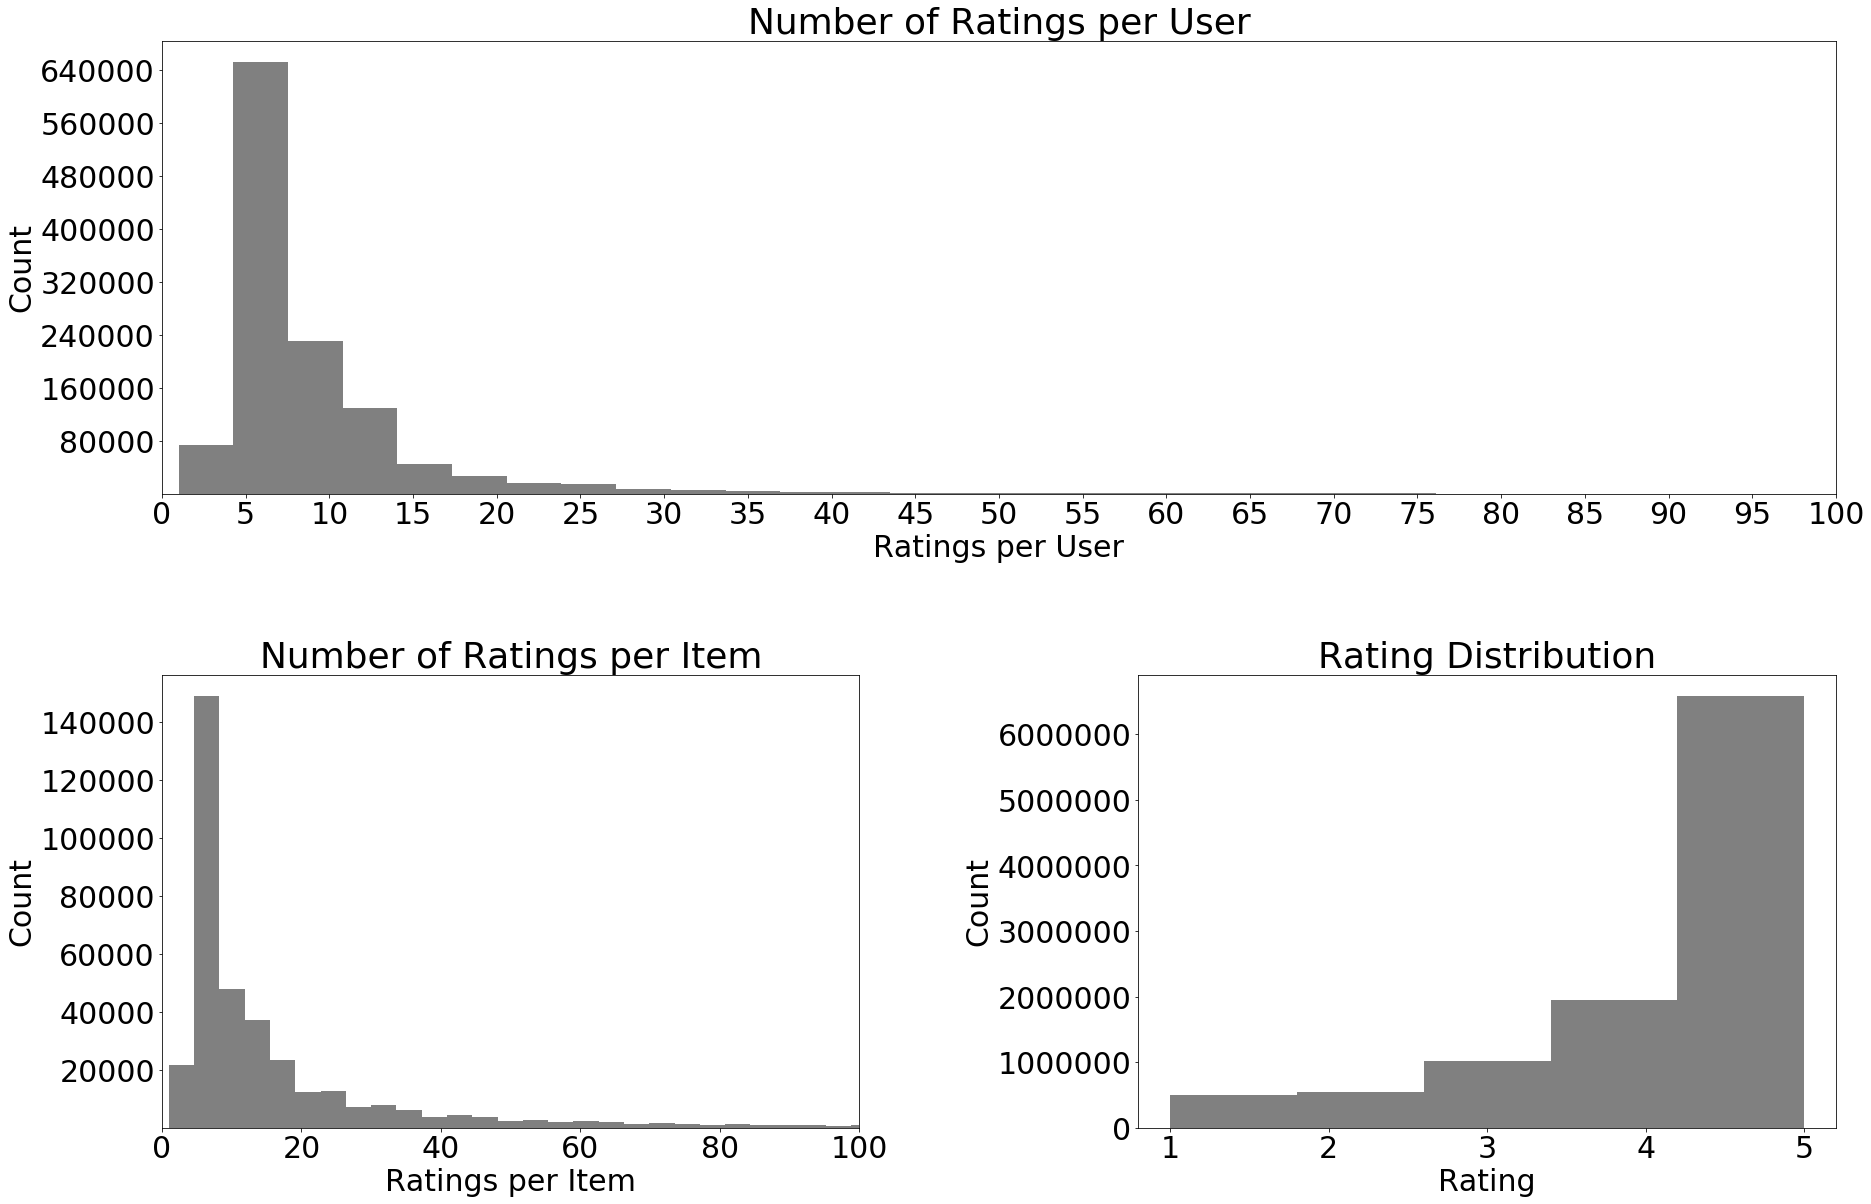

In [122]:
settings = {'item_bins':5000, 'user_bins':150, 'item_xlim':[0,100], 'user_xlim':[0,100], 'user_steps':5}
eda_plots(df_am, '', size=(30,20), store_path=path+'Plots/EDA/am_full', color='grey', **settings)

## EDA ML Full

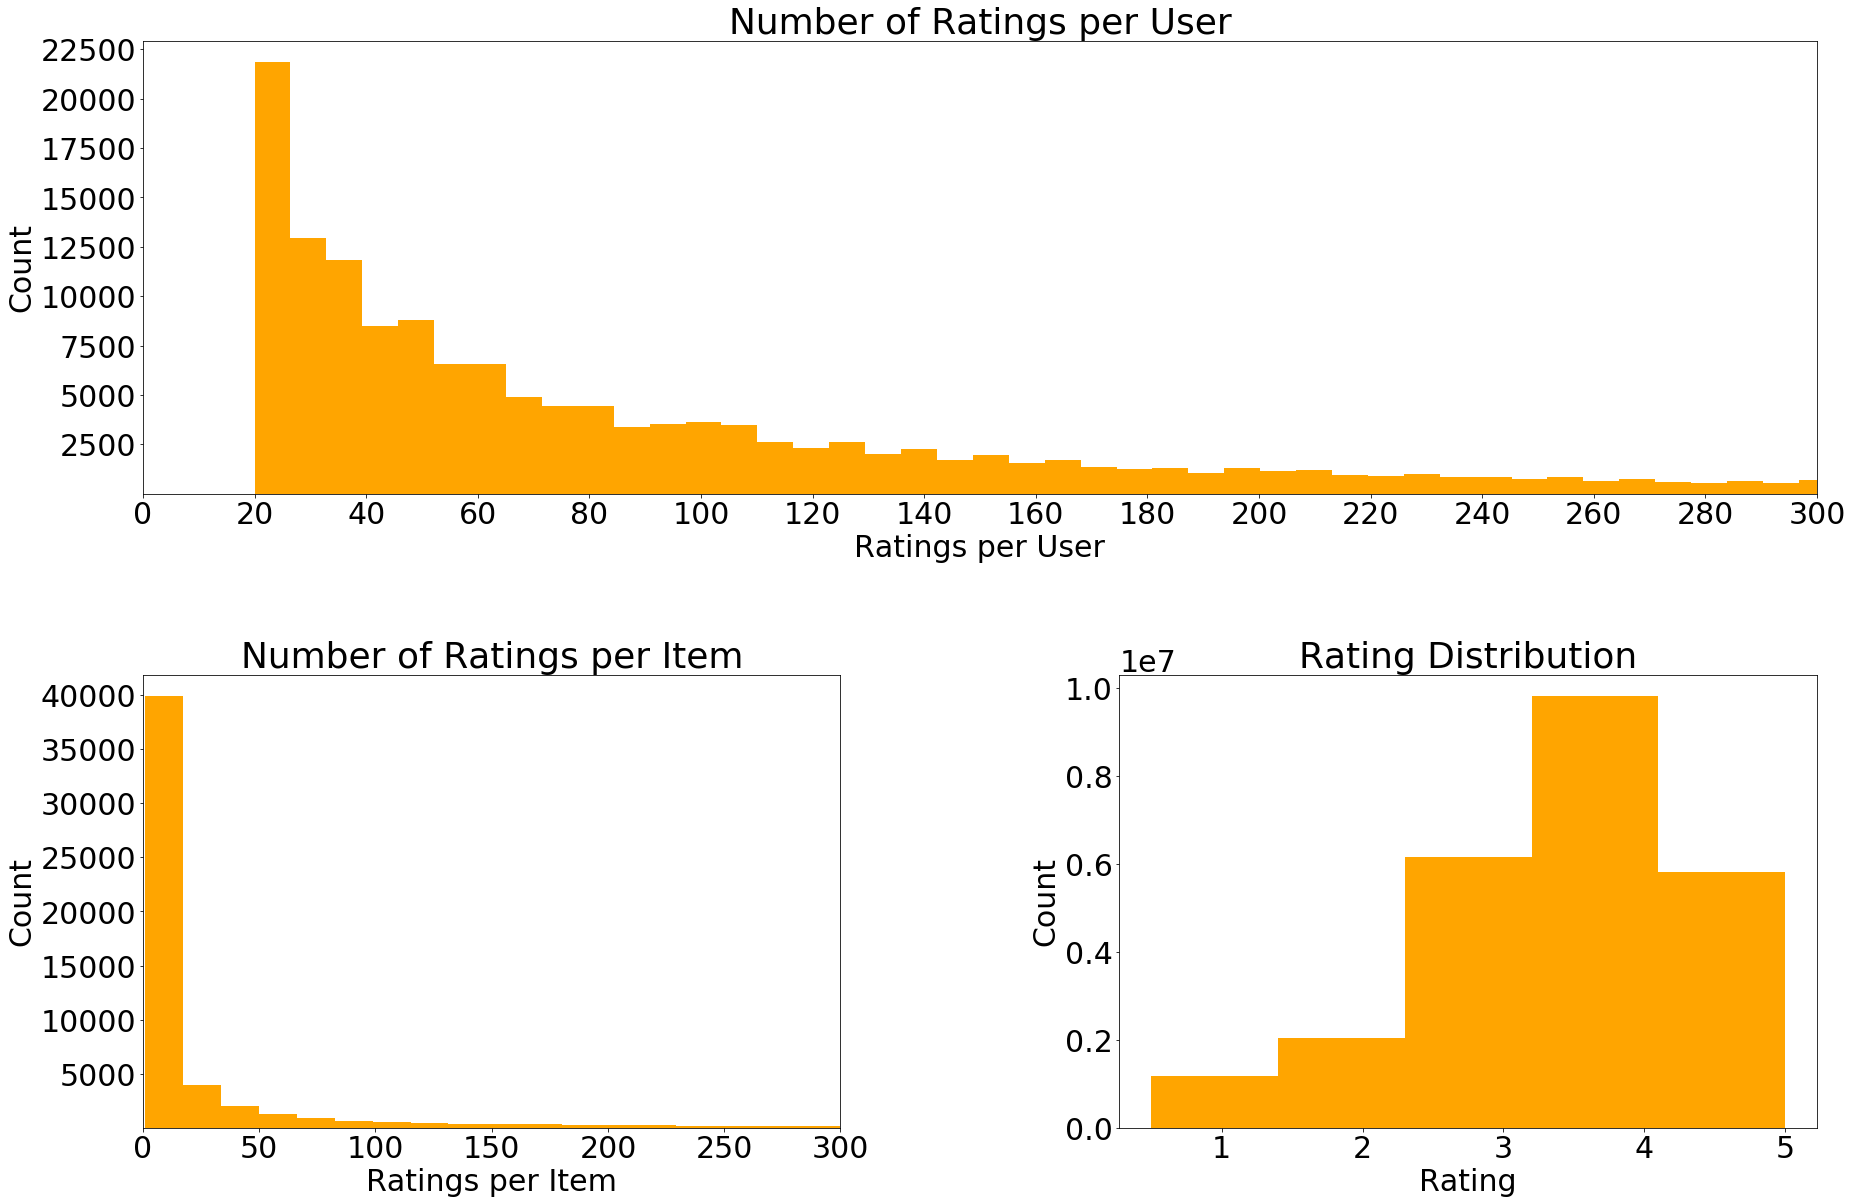

In [123]:
settings = {'item_bins':5000, 'user_bins':5000, 'item_xlim':[0,300], 'user_xlim':[0,300], 'user_steps':20}
eda_plots(df_ml, '', size=(30,20), store_path=path+'Plots/EDA/ml_full', color='orange', **settings)

## EDA Amazon 20k Users

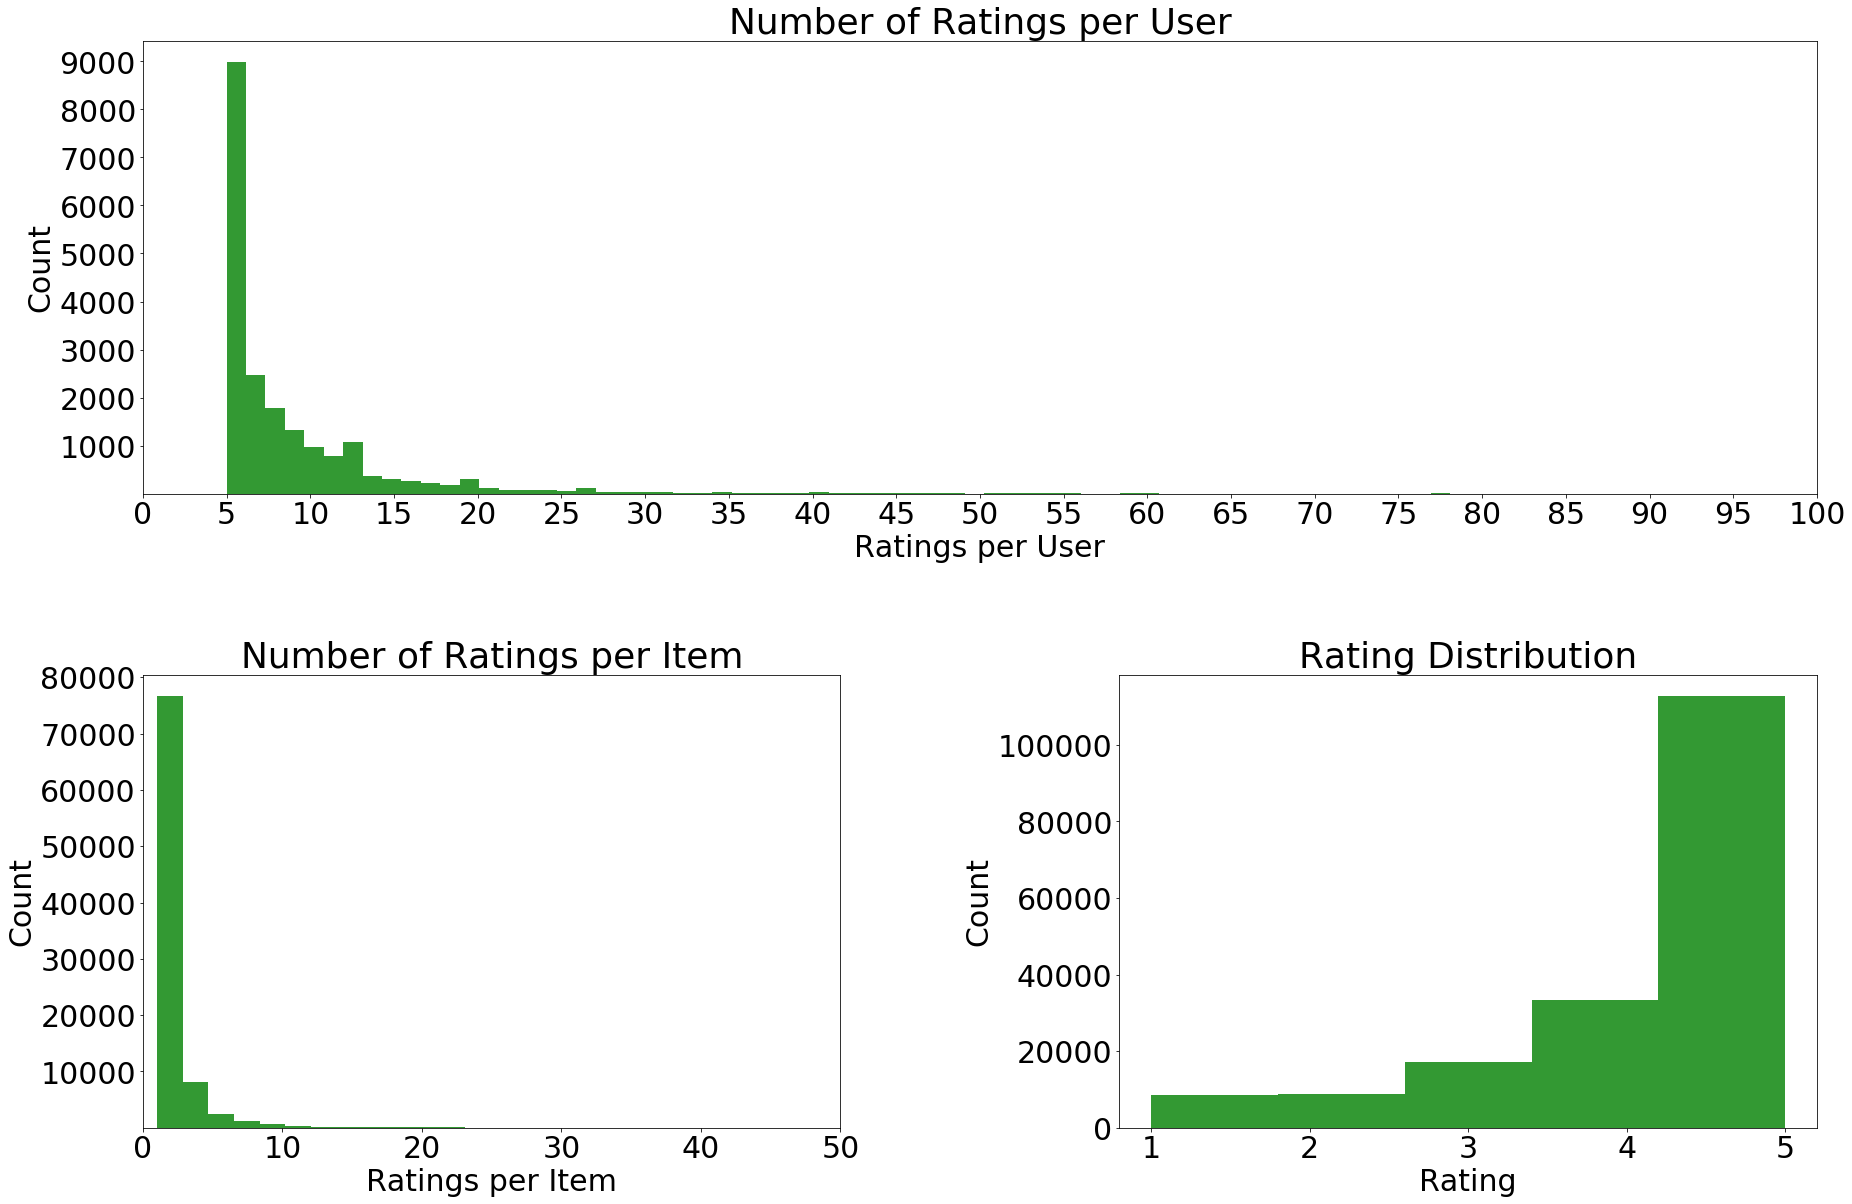

In [52]:
settings = {'item_bins':150, 'user_bins':150, 'item_xlim':[0,50], 'user_xlim':[0,100], 'user_steps':5}
eda_plots(am_20k_users, '', size=(30,20), store_path=path+'Plots/EDA/am_20k_users', color=colors['am_20k_users'], **settings)

## EDA am_like_ml

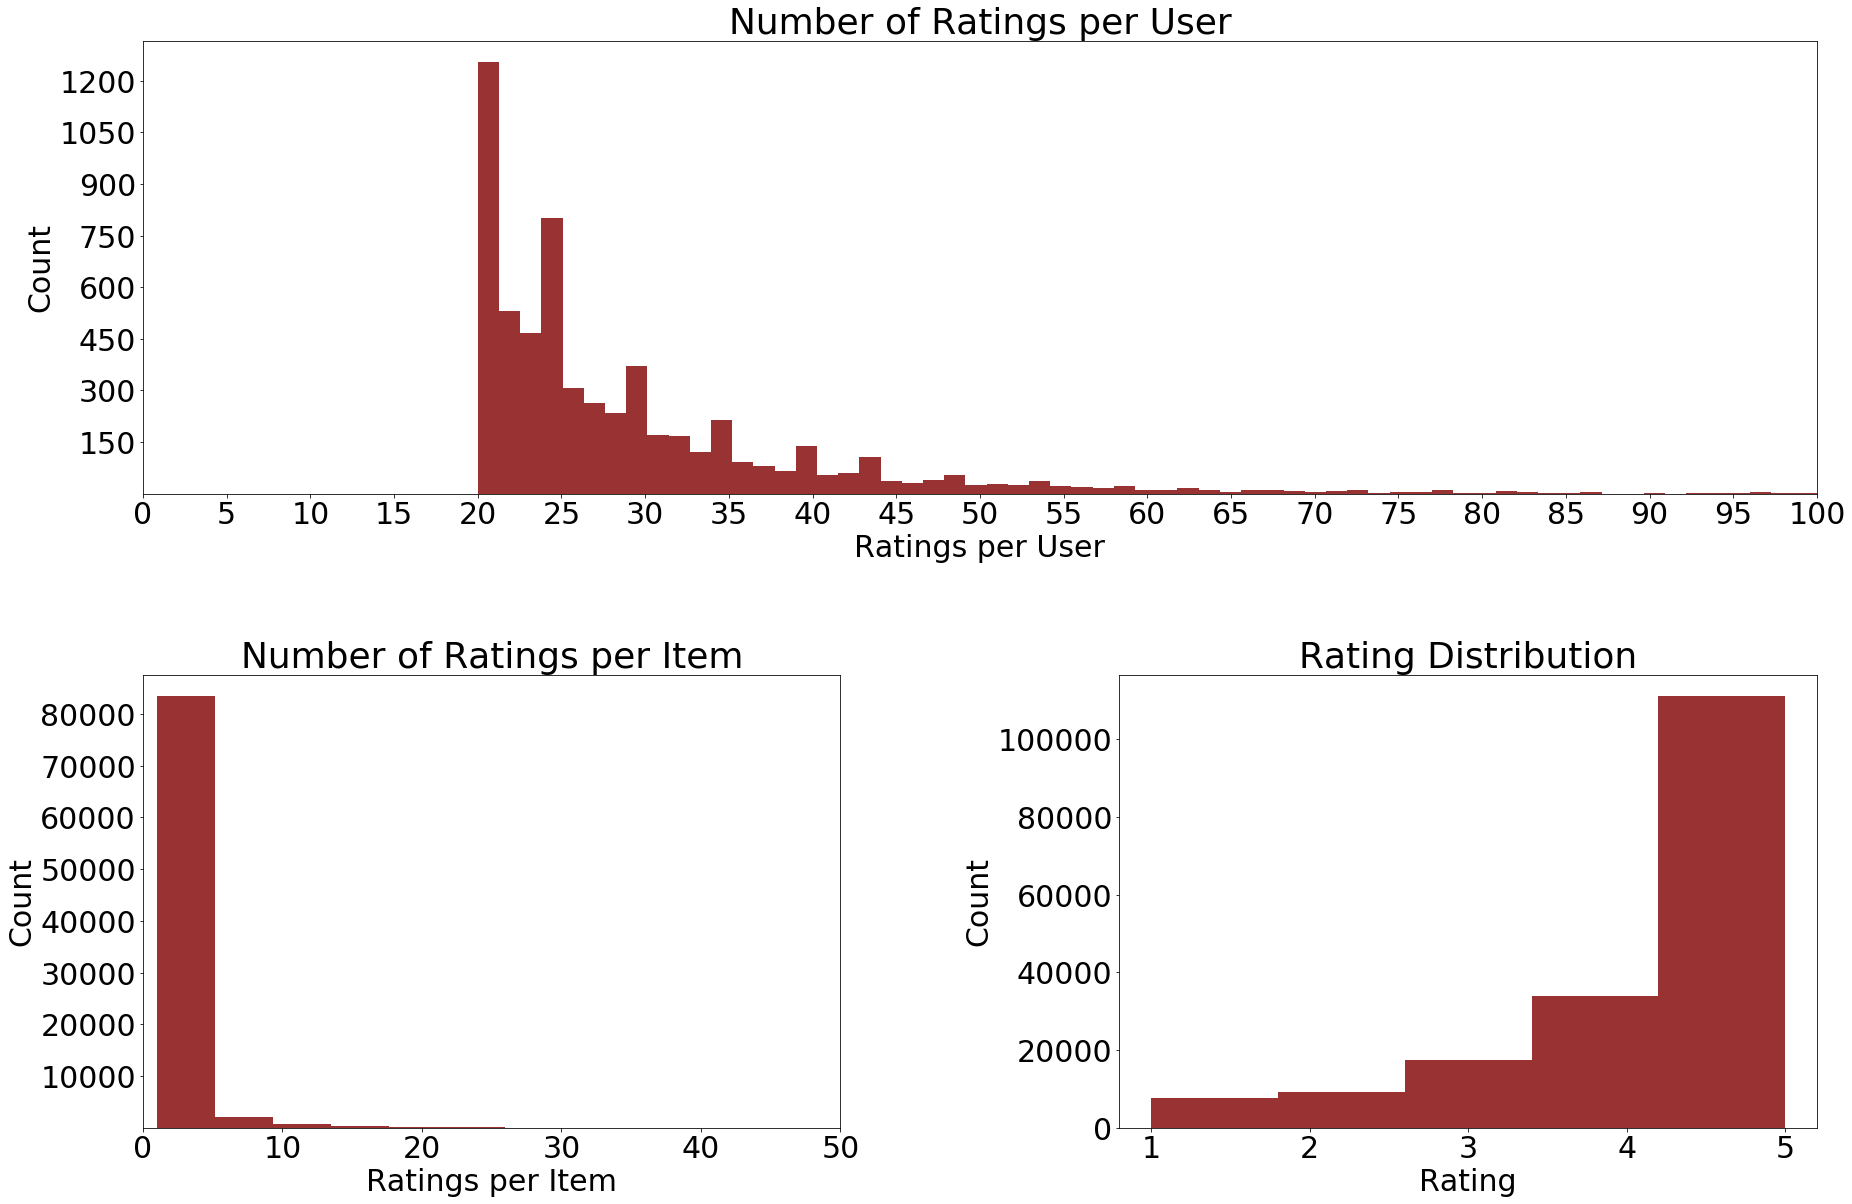

In [53]:
settings = {'item_bins':150, 'user_bins':150, 'item_xlim':[0,50], 'user_xlim':[0,100], 'user_steps':5}
eda_plots(am_like_ml, '', size=(30,20), store_path=path+'Plots/EDA/am_like_ml', color=colors['am_like_ml'], **settings)

## EDA ml_1m

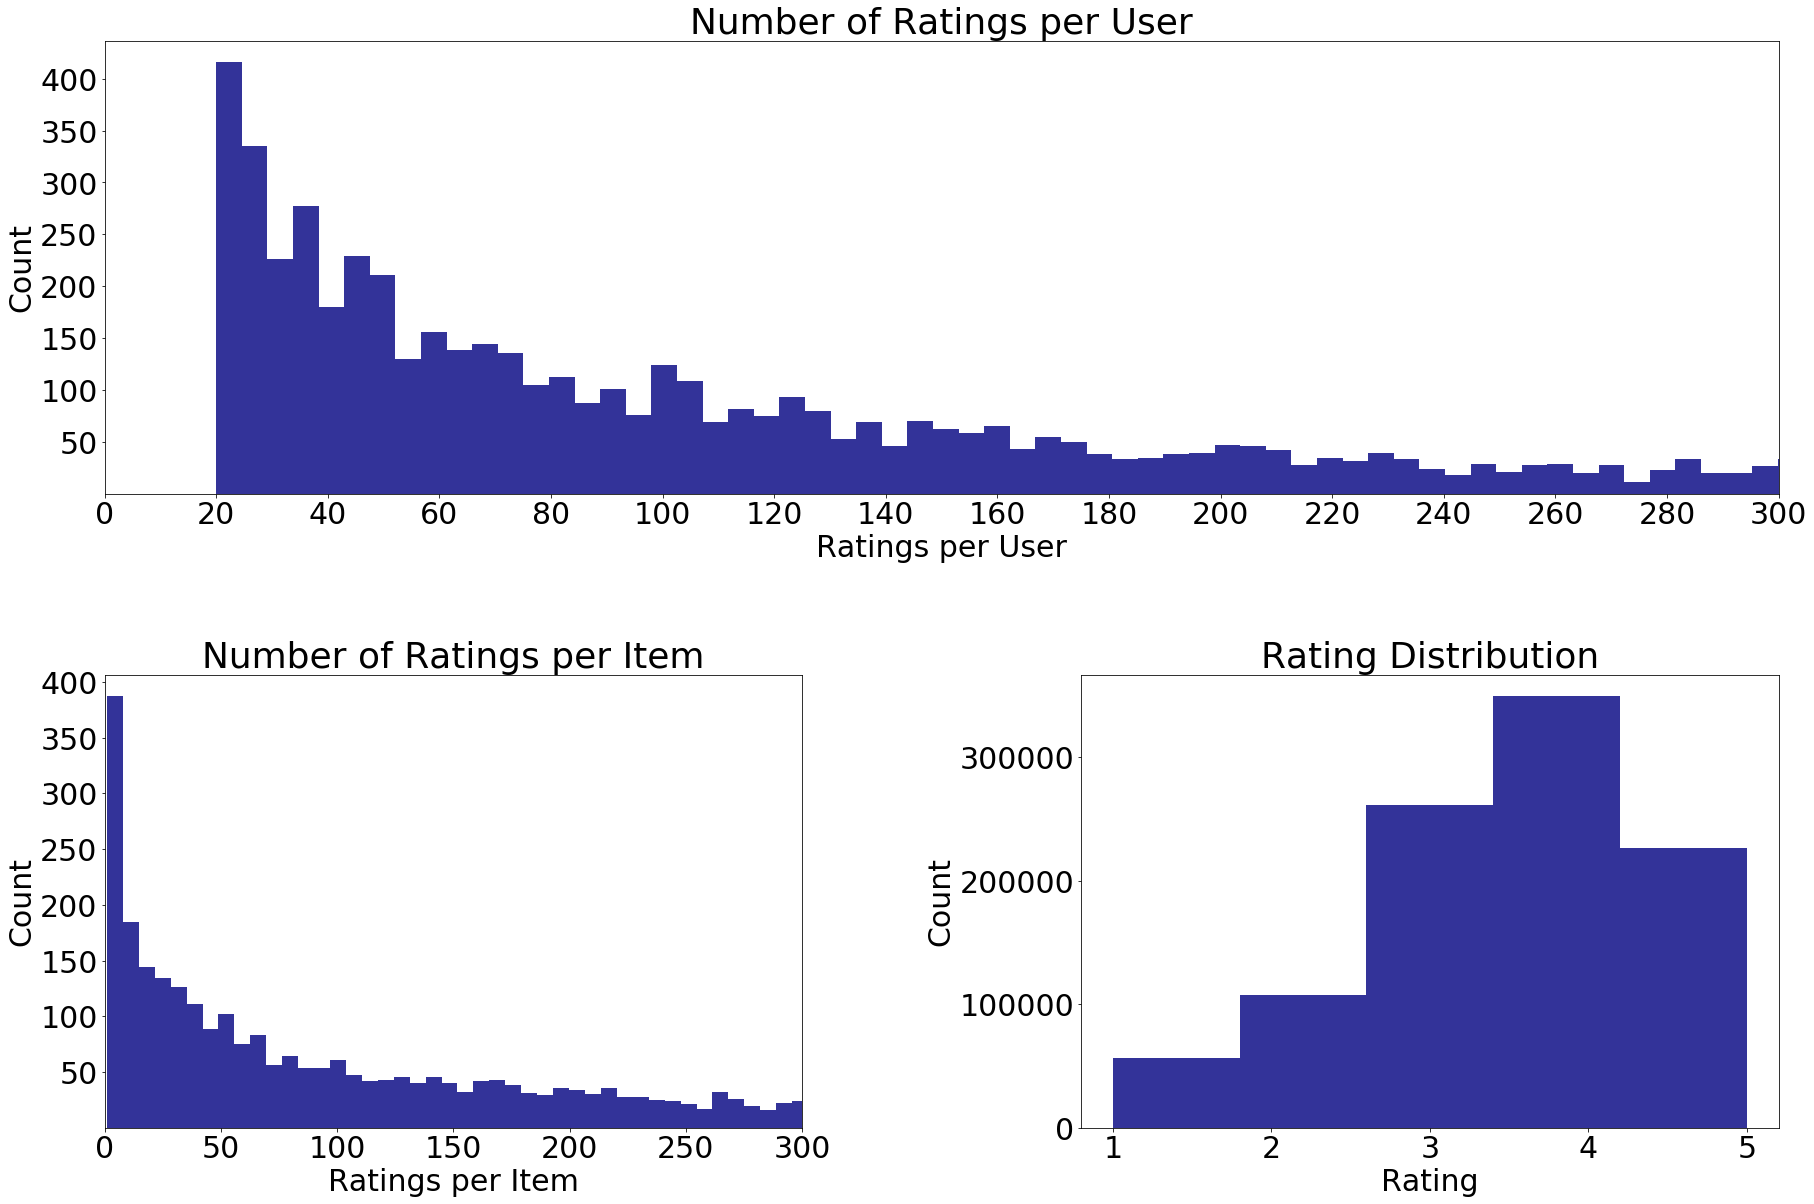

In [54]:
settings = {'item_bins':500, 'user_bins':500, 'item_xlim':[0,300], 'user_xlim':[0,300], 'user_steps':20}
eda_plots(ml_1m, '', size=(30,20), store_path=path+'Plots/EDA/ml_1m', color=colors['ml_1m'], **settings)

---
# EDA tables per dataset

In [59]:
def get_stats(df):
    d = {}
    user_counts = df.groupby('user_id')['item_id'].count()
    item_counts = df.groupby('item_id')['user_id'].count().sort_values(ascending=True)
    d['total_interactions'] = len(df)
    d['avg rating'] = df.rating.mean()
    d['avg norpu'] = round(df.groupby('user_id')['item_id'].count().mean(), 2)
    d['median norpu'] = round(df.groupby('user_id')['item_id'].count().median(), 2)
    d['avg norpi'] = round(df.groupby('item_id')['user_id'].count().mean(), 2)
    d['median norpi'] = round(df.groupby('item_id')['user_id'].count().median(), 2)
    d['total_users'] = df.user_id.nunique()
    d['total_items'] = df.item_id.nunique()
    d['sparseness'] = 1 - len(df) / (len(df['user_id'].unique()) * len(df['item_id'].unique()))
    
    return pd.DataFrame.from_dict(d, orient='index')

In [60]:
import xlsxwriter
dfs = [df_am, df_ml, am_20k_users, ml_1m, am_like_ml]
sheet_names = ['am_full', 'ml_full', 'am_20k', 'ml_1m', 'am_like_ml']

writer = pd.ExcelWriter(path + 'Data/EDA/' + 'eda_dfs.xlsx', engine='xlsxwriter')
for df, sheet_name in zip(dfs, sheet_names):
    res = get_stats(df)[0]
#     print(res)
    res.to_excel(writer, sheet_name=sheet_name)

writer.save()

In [17]:
df_ml.columns

Index(['user', 'item', 'rating', 'datetime', 'item_id', 'user_id'], dtype='object')

---
# Long-tail focused EDA plots

In [74]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator

def eda_plots_long_tail(df, title, size=(20,16), store_path='', color=(), **kwargs):
    
    user_counts = df.groupby('user_id')['item_id'].count()
    item_counts = df.groupby('item_id')['user_id'].count().sort_values(ascending=True)
    norpu = user_counts.mean()
    norpi = item_counts.mean()
    
    fig = plt.figure(figsize=size)
    if len(title) > 0:
        fig.suptitle(title, x=0.5, y=0.95, fontsize=22)
    gs = fig.add_gridspec(4,2, wspace=0.4, hspace=0.4)
    
    f_ax1 = fig.add_subplot(gs[0,0:])
    plt.hist(user_counts, bins = kwargs['user_bins'], color=color)
    plt.xticks(np.arange(0, kwargs['user_bins'], kwargs['user_steps']), np.arange(0, kwargs['user_bins'], kwargs['user_steps']))
    plt.xlim(kwargs['user_xlim'])
    plt.title('Number of Ratings per User')
    plt.xlabel('Ratings per User')
    plt.ylabel('Count')
    plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
    plt.gca().xaxis.get_majorticklabels()[0].set_x(-0.05)
    
    f_ax = fig.add_subplot(gs[1,0:])
    plt.hist(user_counts, bins = kwargs['user_bins'], color=color)
    plt.xticks(np.arange(0, kwargs['user_bins_2'], kwargs['user_steps_2']), np.arange(0, kwargs['user_bins_2'], kwargs['user_steps_2']))
    plt.xlim(kwargs['user_xlim_2'])
    plt.ylim(kwargs['user_ylim_2'])
    plt.title('Number of Ratings per User (long-tail focus)')
    plt.xlabel('Ratings per User')
    plt.ylabel('Count')
    plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
    plt.gca().xaxis.get_majorticklabels()[0].set_x(-0.05)
    
    f_ax3 = fig.add_subplot(gs[2,0:])
    plt.hist(item_counts, bins = kwargs['item_bins'], color=color)
    plt.xticks(np.arange(0, kwargs['item_bins'], kwargs['item_steps']), np.arange(0, kwargs['item_bins'], kwargs['item_steps']))
    plt.xlim(kwargs['item_xlim'])
    plt.title('Number of Ratings per Item')
    plt.xlabel('Ratings per Item')
    plt.ylabel('Count')
    plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
    plt.gca().xaxis.get_majorticklabels()[0].set_x(-0.05)
    
    f_ax3 = fig.add_subplot(gs[3,0:])
    plt.hist(item_counts, bins = kwargs['item_bins_2'], color=color)
    plt.xticks(np.arange(0, kwargs['item_bins_2'], kwargs['item_steps_2']), np.arange(0, kwargs['item_bins_2'], kwargs['item_steps_2']))
    plt.xlim(kwargs['item_xlim_2'])
    plt.ylim(kwargs['item_ylim_2'])
    plt.title('Number of Ratings per Item (long-tail focus)')
    plt.xlabel('Ratings per Item')
    plt.ylabel('Count')
    plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
    plt.gca().xaxis.get_majorticklabels()[0].set_x(-0.05)


    if len(store_path) > 0:
        fig.savefig(store_path + '.pdf', bbox_inches='tight')
        
    plt.show()

In [75]:
plt.rcParams.update({'font.size':30})

## EDA Amazon 20k Users

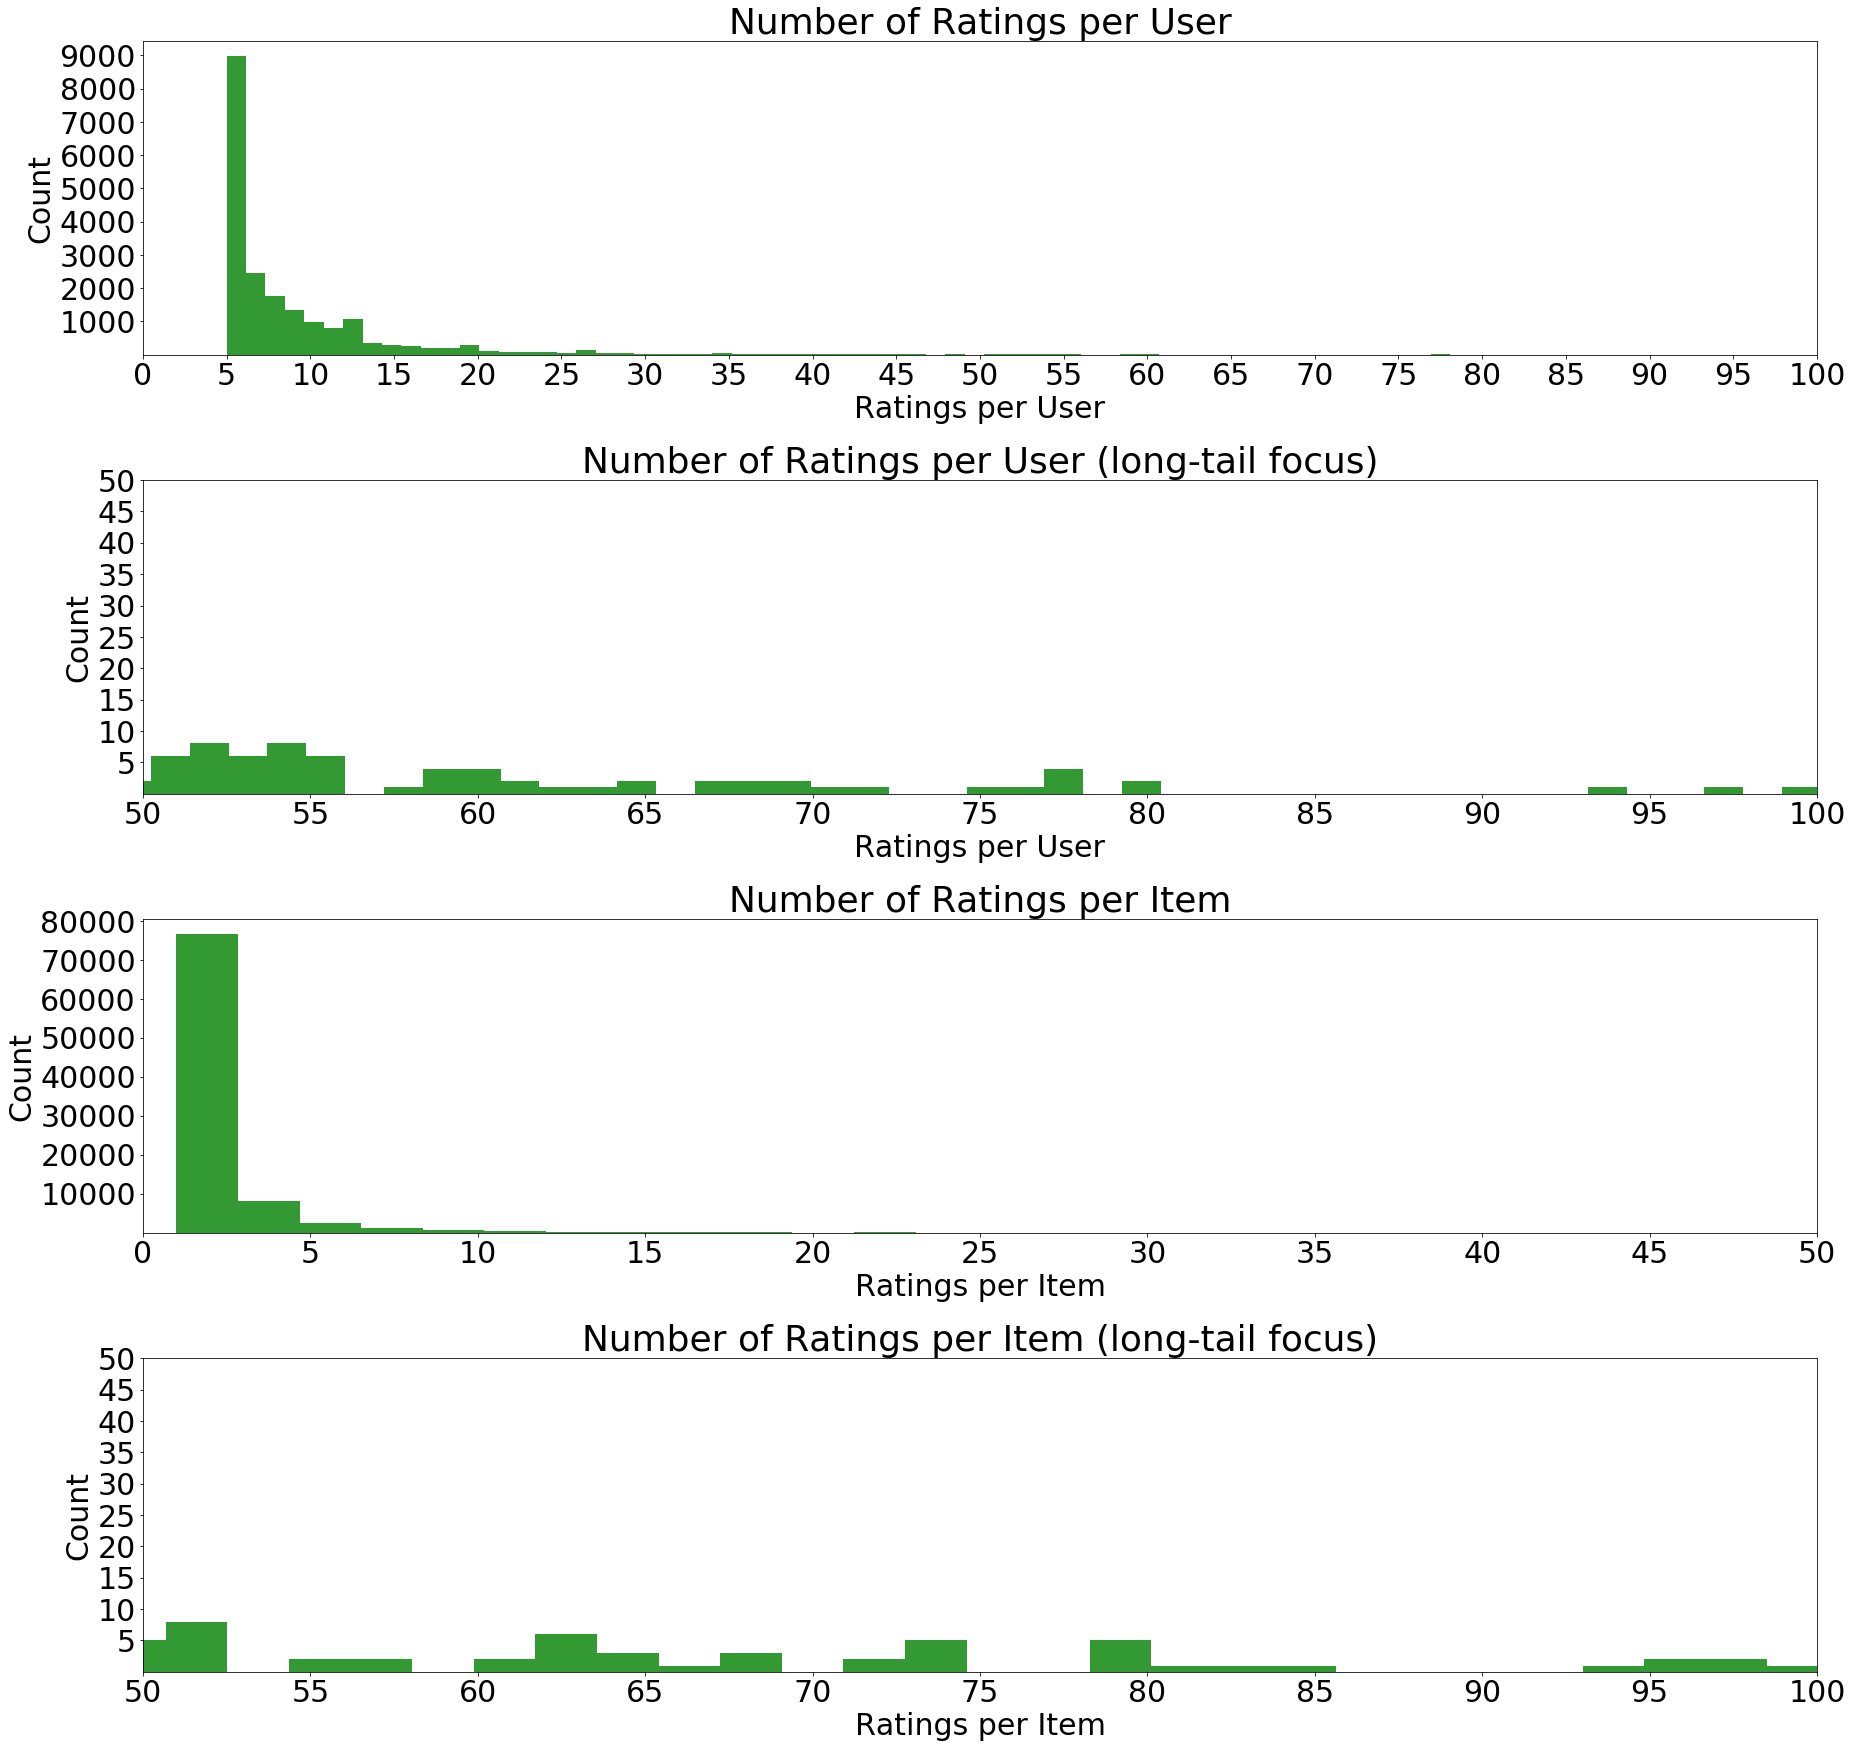

In [124]:
settings = {'user_bins':150, 'user_bins_2':150, 'user_xlim':[0,100], 'user_xlim_2':[50,100], 'user_steps':5, 'user_steps_2':5, 'user_ylim_2':[0,50],
            'item_bins':150, 'item_bins_2':150, 'item_xlim':[0,50], 'item_xlim_2':[50,100], 'item_steps':5, 'item_steps_2':5, 'item_ylim_2':[0,50]}
eda_plots_long_tail(am_20k_users, '', size=(30,30), store_path=path+'Plots/EDA/am_20k_users_long_tail', color=colors['am_20k_users'], **settings)

## EDA am_like_ml

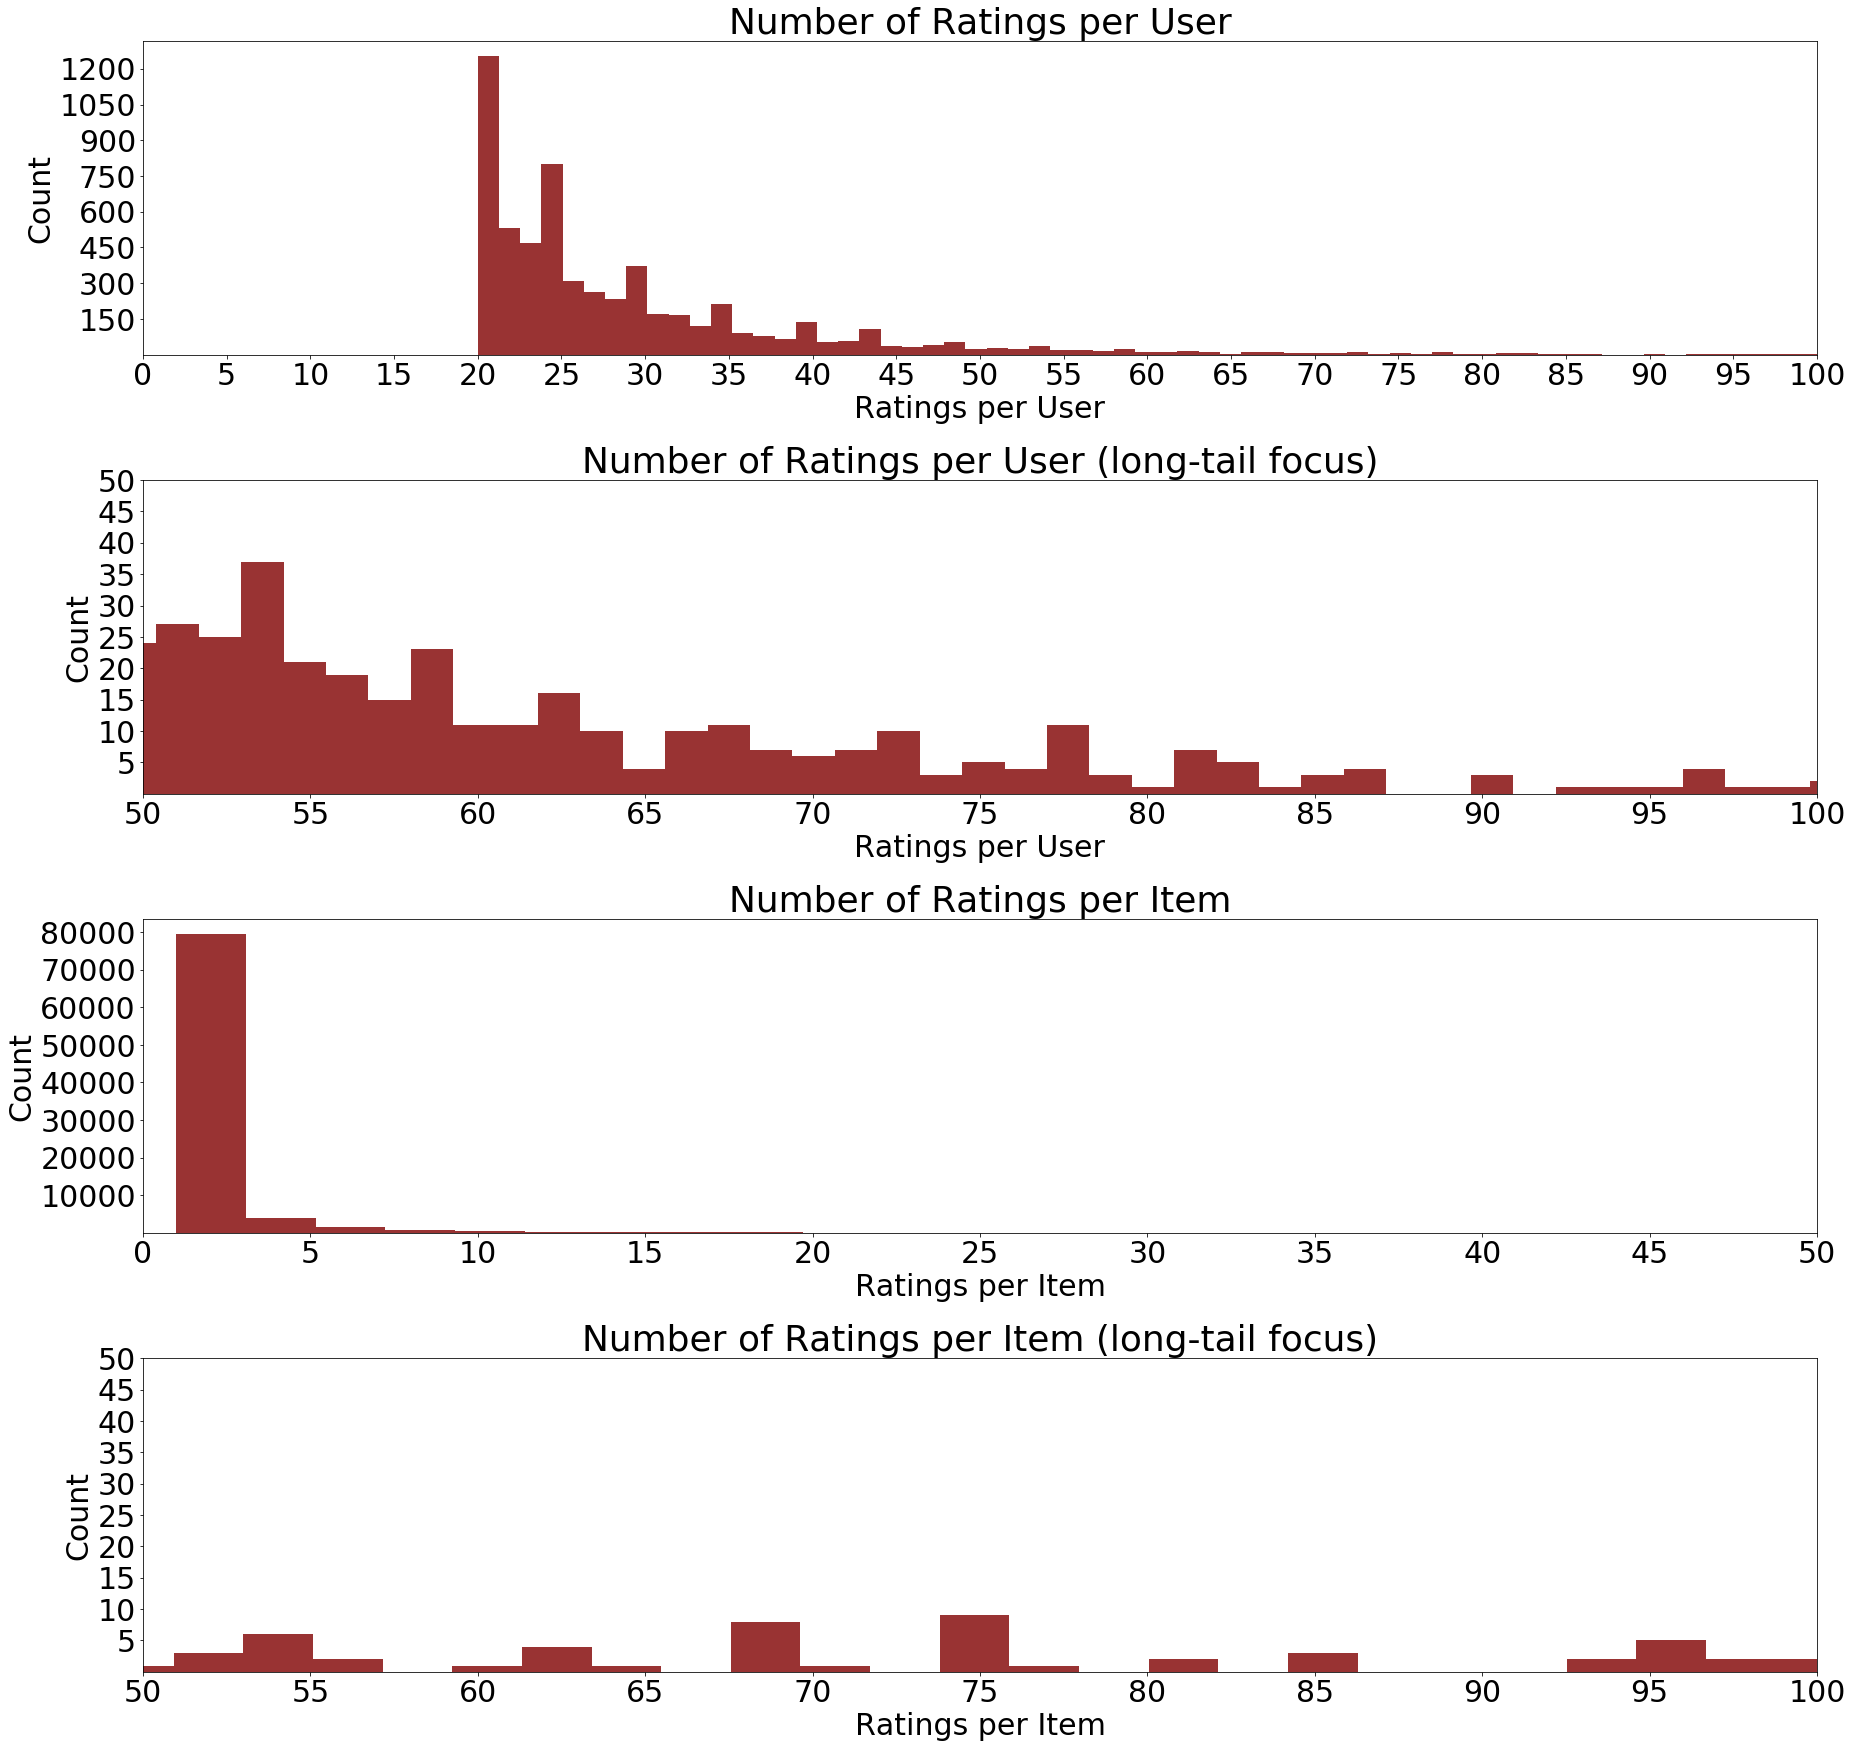

In [125]:
settings = {'user_bins':150, 'user_bins_2':150, 'user_xlim':[0,100], 'user_xlim_2':[50,100], 'user_steps':5, 'user_steps_2':5, 'user_ylim_2':[0,50],
            'item_bins':300, 'item_bins_2':300, 'item_xlim':[0,50], 'item_xlim_2':[50,100], 'item_steps':5, 'item_steps_2':5, 'item_ylim_2':[0,50]}
eda_plots_long_tail(am_like_ml, '', size=(30,30), store_path=path+'Plots/EDA/am_like_ml_long_tail', color=colors['am_like_ml'], **settings)

## EDA ml_1m

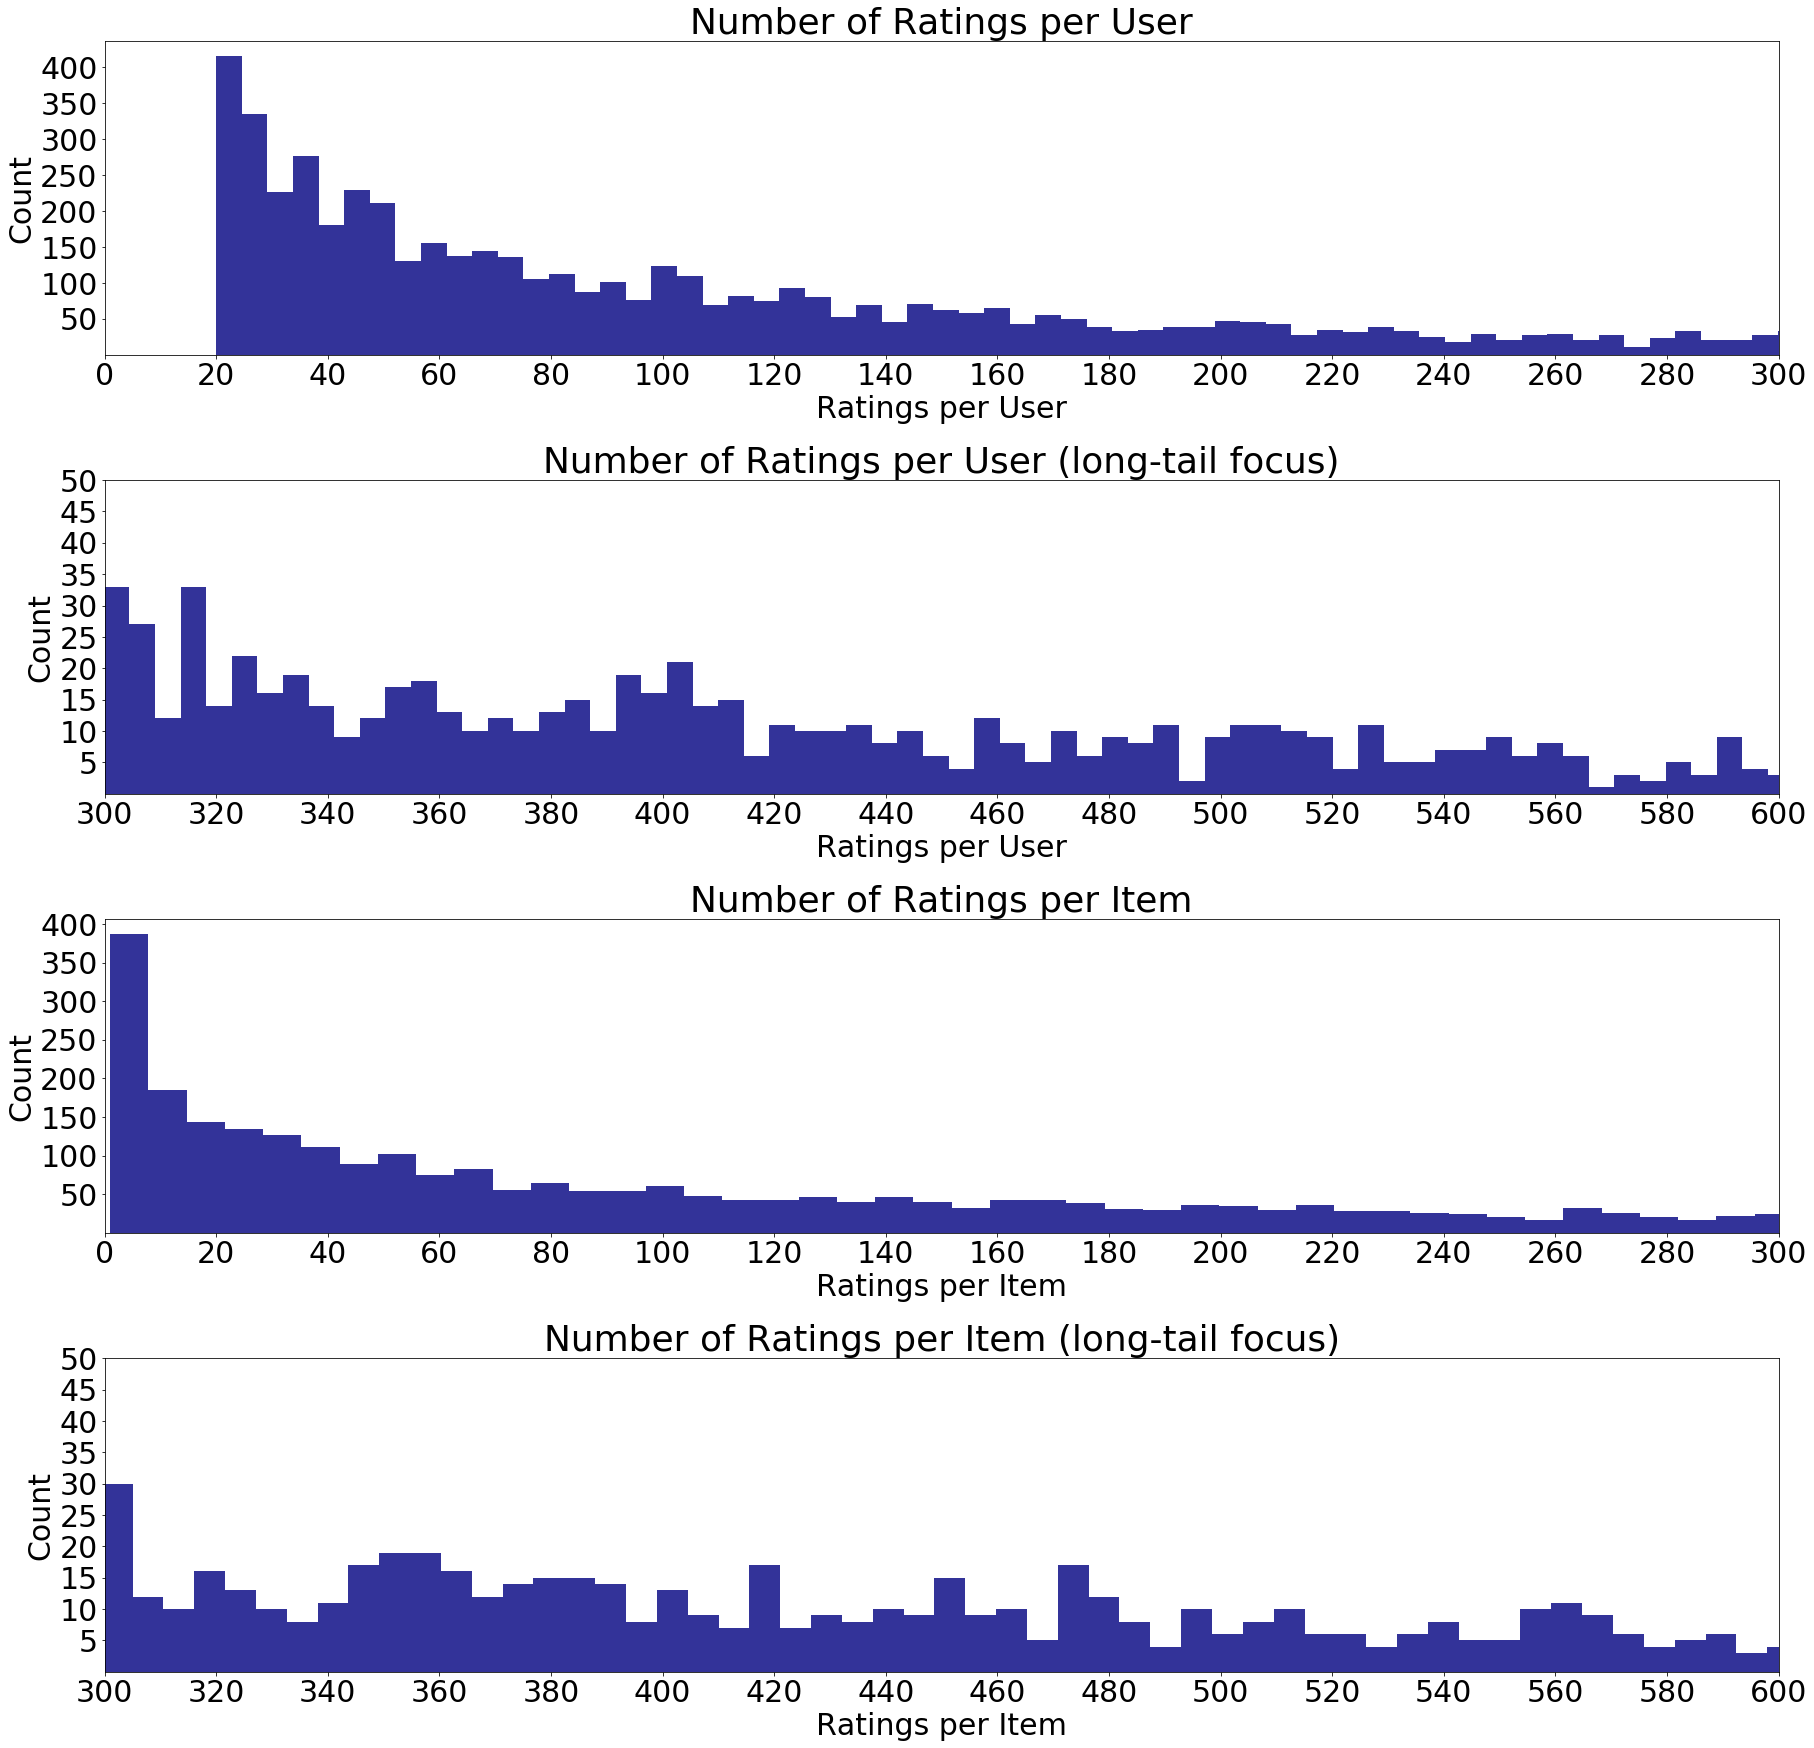

In [126]:
settings = {'user_bins':500, 'user_bins_2':620, 'user_xlim':[0,300], 'user_xlim_2':[300,600], 'user_steps':20, 'user_steps_2':20, 'user_ylim_2':[0,50],
            'item_bins':500, 'item_bins_2':620, 'item_xlim':[0,300], 'item_xlim_2':[300,600], 'item_steps':20, 'item_steps_2':20, 'item_ylim_2':[0,50]}
# settings = {'item_bins':500, 'user_bins':500, 'item_xlim':[0,300], 'user_xlim':[0,300], 'user_steps':20}
eda_plots_long_tail(ml_1m, '', size=(30,30), store_path=path+'Plots/EDA/ml_1m_long_tail', color=colors['ml_1m'], **settings)